In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from epam.dnsm import TransformerBinarySelectionModel, DNSMBurrito
from epam.sequences import translate_sequences

In [2]:
pcp_df = pd.read_csv("~/data/wyatt-10x-1p5m_pcp_2023-10-07.mimic-only_allow_mutations_next_to_hydrophobic_sites.csv")

# filter out rows of pcp_df where the parent and child sequences are identical
pcp_df = pcp_df[pcp_df["parent"] != pcp_df["child"]]

# NOTE downsampling here
pcp_df = pcp_df.sample(5000, random_state=42)

print(f"We have {len(pcp_df)} PCPs.")

We have 5000 PCPs.


In [3]:
shmple_weights_directory = "/Users/matsen/re/epam/data/shmple_weights/my_shmoof"
nhead = 2
dim_feedforward = 2048
layer_count = 2

dnsm = TransformerBinarySelectionModel(
    nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
)

burrito = DNSMBurrito(pcp_df, shmple_weights_directory, dnsm, batch_size=1024, learning_rate=0.001, checkpoint_dir="./_checkpoints", log_dir="./_logs")

Using Metal Performance Shaders
preparing data...


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
predicting mutabilities and substitutions...
consolidating this into substitution probabilities...


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def selection_factor_neighbor_plot(model):
    parents = pcp_df.reset_index(drop=True)["parent"]
    if len(parents) > 1000:
        parents = parents.sample(1000)
    aa_parents = translate_sequences(parents)
    selection_factor_arrays = [model.selection_factors_of_aa_str(aa_str).cpu().numpy() for aa_str in aa_parents]

    hydrophobic_aas = set(list("AILMFWV"))

    def selection_factor_means(aa_str, selection_factor_array):
        adjacent_hydrophobic_selection_factors = []
        other_selection_factors = []
        
        # Check for each position in the amino acid string
        for i, aa in enumerate(aa_str):
            if aa not in hydrophobic_aas:
                if (i > 0 and aa_str[i-1] in hydrophobic_aas) or \
                   (i < len(aa_str) - 1 and aa_str[i+1] in hydrophobic_aas):
                    # The current amino acid is adjacent to a hydrophobic one
                    adjacent_hydrophobic_selection_factors.append(selection_factor_array[i])
                else:
                    other_selection_factors.append(selection_factor_array[i])
        
        return {
            "adjacent_hydrophobic_selection_mean": np.mean(adjacent_hydrophobic_selection_factors) if adjacent_hydrophobic_selection_factors else np.nan,
            "other_selection_mean": np.mean(other_selection_factors) if other_selection_factors else np.nan
        }

    df = pd.DataFrame([selection_factor_means(aa_str, selection_factor_array) for aa_str, selection_factor_array in zip(aa_parents, selection_factor_arrays)])

    # Scatter plot
    plt.scatter(df['adjacent_hydrophobic_selection_mean'], df['other_selection_mean'], label='sequences', alpha=0.1)
    plt.xlabel('Adjacent Hydrophobic Selection Mean')
    plt.ylabel('Other Selection Mean')

    # Add x=y line
    lims = [
        np.nanmin([plt.xlim(), plt.ylim()]),  
        np.nanmax([plt.xlim(), plt.ylim()]),  
    ]
    plt.plot(lims, lims, 'k--', alpha=0.5, label='x=y line')
    plt.xlim(lims)
    plt.ylim(lims)

    plt.legend()
    plt.show()


In [5]:
burrito.train(15)
burrito.optimize_branch_lengths()
burrito.train(50)
burrito.optimize_branch_lengths()
burrito.train(50)

Epoch [0/15], Training Loss: 0.15902602300047874, Validation Loss: 0.15775974094867706
training model...
Epoch [1/15], Training Loss: 0.14972983300685883, Validation Loss: 0.15728257596492767
Epoch [2/15], Training Loss: 0.1551482230424881, Validation Loss: 0.1558407098054886
Epoch [3/15], Training Loss: 0.15515395998954773, Validation Loss: 0.15570436418056488
Epoch [4/15], Training Loss: 0.16555604338645935, Validation Loss: 0.1557064950466156
Epoch [5/15], Training Loss: 0.16002535820007324, Validation Loss: 0.15543392300605774
Epoch [6/15], Training Loss: 0.15568065643310547, Validation Loss: 0.15547558665275574
Epoch [7/15], Training Loss: 0.15361113846302032, Validation Loss: 0.15541990101337433
Epoch [8/15], Training Loss: 0.15818187594413757, Validation Loss: 0.15525996685028076
Epoch [9/15], Training Loss: 0.15611501038074493, Validation Loss: 0.15513932704925537
Epoch [10/15], Training Loss: 0.15878114104270935, Validation Loss: 0.15500593185424805
Epoch [11/15], Training Los

Finding optimal branch lengths: 100%|██████████| 4000/4000 [12:20<00:00,  5.40it/s]


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...


Finding optimal branch lengths: 100%|██████████| 1000/1000 [02:53<00:00,  5.75it/s]


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
Epoch [0/50], Training Loss: 0.15704813972115517, Validation Loss: 0.15410256385803223
training model...
Epoch [1/50], Training Loss: 0.1549193114042282, Validation Loss: 0.15322166681289673
Epoch [2/50], Training Loss: 0.15453343093395233, Validation Loss: 0.15253446996212006
Epoch [3/50], Training Loss: 0.1524496227502823, Validation Loss: 0.1527080088853836
Epoch [4/50], Training Loss: 0.1543322056531906, Validation Loss: 0.15257273614406586
Epoch [5/50], Training Loss: 0.15283985435962677, Validation Loss: 0.15249118208885193
Epoch [6/50], Training Loss: 0.15027089416980743, Validation Loss: 0.15222948789596558
Epoch [7/50], Training Loss: 0.1547984927892685, Validation Loss: 0.15213780105113983
Epoch [8/50], Training Loss: 0.15634877979755402, Validation Loss: 0.1513683795928955
Epoch [9/50], Training Loss: 0.1545920968055725, Validation Loss: 0.15189941227436066
Epoch [10/50], Train

Finding optimal branch lengths:   0%|          | 0/4000 [00:00<?, ?it/s]/Users/matsen/re/epam/epam/models.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_branch_length = torch.tensor(np.log(base_branch_length), requires_grad=True)
Finding optimal branch lengths: 100%|██████████| 4000/4000 [12:08<00:00,  5.49it/s]


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...


Finding optimal branch lengths: 100%|██████████| 1000/1000 [02:53<00:00,  5.76it/s]


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
Epoch [0/50], Training Loss: 0.15338977798819542, Validation Loss: 0.1496734619140625
training model...
Epoch [1/50], Training Loss: 0.15136969089508057, Validation Loss: 0.14857739210128784
Epoch [2/50], Training Loss: 0.15120352804660797, Validation Loss: 0.14787288010120392
Epoch [3/50], Training Loss: 0.152703195810318, Validation Loss: 0.14830714464187622
Epoch [4/50], Training Loss: 0.1427270621061325, Validation Loss: 0.147497296333313
Epoch [5/50], Training Loss: 0.15326398611068726, Validation Loss: 0.1473391056060791
Epoch [6/50], Training Loss: 0.15148885548114777, Validation Loss: 0.14718769490718842
Epoch [7/50], Training Loss: 0.15122538805007935, Validation Loss: 0.14831529557704926
Epoch [8/50], Training Loss: 0.15551811456680298, Validation Loss: 0.14748802781105042
Epoch [9/50], Training Loss: 0.14741827547550201, Validation Loss: 0.14741648733615875
Epoch [10/50], Train

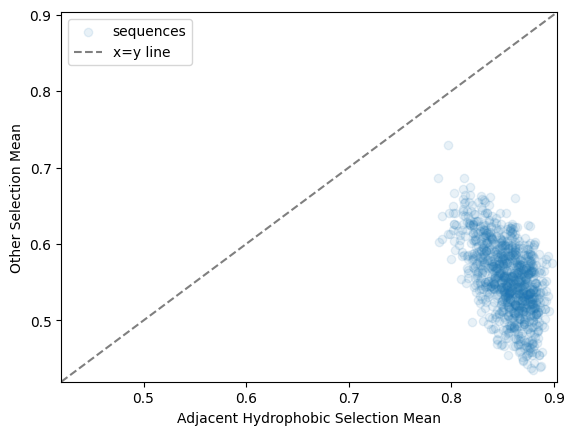

In [11]:
selection_factor_neighbor_plot(burrito.dnsm)

In [7]:
[aa_str] = translate_sequences([pcp_df.reset_index(drop=True).loc[0, "parent"]])
burrito.dnsm.selection_factors_of_aa_str(aa_str)

tensor([1.0000, 0.3404, 1.0000, 1.0000, 1.0000, 1.0000, 0.3699, 0.2647, 0.5751,
        0.3120, 1.0000, 0.9896, 1.0000, 0.2039, 0.4296, 0.6883, 1.0000, 0.9150,
        1.0000, 0.9080, 1.0000, 0.8667, 0.9135, 1.0000, 0.9753, 0.5552, 0.6148,
        1.0000, 0.5744, 1.0000, 0.3843, 0.5618, 0.8210, 0.7241, 1.0000, 0.9318,
        1.0000, 1.0000, 0.7483, 0.9006, 0.7673, 0.2212, 0.4471, 0.2599, 0.2564,
        0.9592, 0.8758, 0.8645, 0.2933, 0.6296, 0.5564, 0.8262, 0.3807, 0.2497,
        0.2750, 0.2213, 0.2139, 0.2657, 0.3391, 0.5142, 0.5884, 0.6145, 0.3408,
        0.9437, 0.9584, 0.4969, 1.0000, 0.5982, 0.7882, 0.4765, 0.8043, 0.7112,
        0.9897, 0.6766, 0.3867, 0.4269, 0.6056, 0.9919, 0.7495, 1.0000, 0.2154,
        0.9065, 0.3845, 1.0000, 1.0000, 0.3969, 0.7658, 1.0000, 0.9434, 0.6681,
        0.9421, 0.9014, 1.0000, 0.7953, 0.6644, 0.8379, 0.8619, 1.0000, 0.9325,
        1.0000, 0.7932, 0.9116, 0.6792, 0.7277, 0.8618, 0.5794, 0.8964, 0.9823,
        0.5297, 0.9933, 1.0000, 0.9783, 

In [8]:
# nhead = 4
# dim_feedforward = 2048
# layer_count = 3
# 
# model = TransformerBinarySelectionModel(
#     nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
# )
# 
# model.load_state_dict(torch.load("../_trained_dnsms/dnsm-hydrophobic-2023-11-01.pth")["model_state_dict"])
# model.eval()



In [12]:
# model = TransformerBinarySelectionModel(
#     nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
# )
nobl_trained_dnsm = TransformerBinarySelectionModel(
    nhead=nhead, dim_feedforward=dim_feedforward, layer_count=layer_count
)

nobl_trained_burrito = DNSMBurrito(pcp_df, shmple_weights_directory, nobl_trained_dnsm, batch_size=1024, learning_rate=0.001, checkpoint_dir="./_checkpoints", log_dir="./_logs")

nobl_trained_burrito.train(50)

model = nobl_trained_burrito.dnsm


Using Metal Performance Shaders
preparing data...


predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
predicting mutabilities and substitutions...
consolidating this into substitution probabilities...
Epoch [0/50], Training Loss: 0.16135390847921371, Validation Loss: 0.15873435139656067
training model...
Epoch [1/50], Training Loss: 0.15487875044345856, Validation Loss: 0.1551513373851776
Epoch [2/50], Training Loss: 0.15810620784759521, Validation Loss: 0.15548677742481232
Epoch [3/50], Training Loss: 0.1541561782360077, Validation Loss: 0.15468989312648773
Epoch [4/50], Training Loss: 0.15527212619781494, Validation Loss: 0.15572282671928406
Epoch [5/50], Training Loss: 0.15986977517604828, Validation Loss: 0.154585063457489
Epoch [6/50], Training Loss: 0.1577870100736618, Validation Loss: 0.15486346185207367
Epoch [7/50], Training Loss: 0.1523590385913849, Validation Loss: 0.15357092022895813
Epoch [8/50], Training Loss: 0.15852025151252747, Validation Loss: 0.15352673828601837
Epoch [

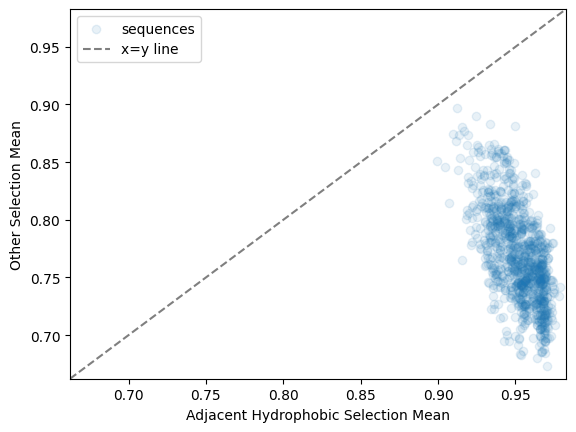

In [13]:
selection_factor_neighbor_plot(nobl_trained_burrito.dnsm)